In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col


In [2]:
df = pd.read_csv("growthdata_public.csv")
df.columns = df.columns.str.strip()

c)

Here I prepare and run fixed-effects panel regressions using OLS with the statsmodels library. First, key transformed variables (such as lags, differences, and squared terms) are generated to reflect economic relationships. The prep_data() function constructs the design matrix by combining the selected explanatory variables with country and period fixed effects, which are added using dummy variables. All inputs are converted to numeric types, missing values are dropped, and a constant is added to the model. 

In [3]:
df["lEDI_ipol_sq"] = df["lEDI_ipol"] ** 2
df["dltot"] = df.groupby("country")["ltot"].diff()
df["durbanpop"] = df.groupby("country")["urbanpop"].diff()
df["dgini"] = df.groupby("country")["gini_mkt"].diff()
df["lagdependent"] = df.groupby("country")["lrgdpna_pc"].shift(1)
df = df.rename(columns={"infrastructure_index": "infra_index"})

def prep_data(df, variables, dep_var="lrgdpna_pc"):
    cols = [dep_var] + variables + ["country", "period"]
    df_model = df[cols].dropna().copy()

    dummies = pd.get_dummies(df_model[["country", "period"]], drop_first=True)
    X = pd.concat([df_model[variables], dummies], axis=1)

    X = X.apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df_model[dep_var], errors="coerce")

    df_clean = pd.concat([y, X], axis=1).dropna()
    y_clean = df_clean[dep_var].astype(float)
    X_clean = sm.add_constant(df_clean.drop(columns=[dep_var])).astype(float)

    return sm.OLS(y_clean, X_clean).fit()
    

dep_var = "lrgdpna_pc"

indep_small = [
    "lagdependent", "linflation_na", "lrer", "ltraderesid", "infra_index",
    "dum_fincrisis", "sd_temperature", "dltot", "lkg", "sd_growth", "durbanpop"]

indep_medium = indep_small + ["lcredit", "lFDIstock_ipol", "lEDI_ipol", "lEDI_ipol_sq", "actotal"]

indep_large = indep_medium + ["lhc", "dgini"]

res_small_sm = prep_data(df, indep_small)
res_medium_sm = prep_data(df, indep_medium)
res_large_sm = prep_data(df, indep_large)

In [4]:
summary = summary_col(
    [res_small_sm, res_medium_sm, res_large_sm],
    stars=True,
    model_names=["(1) small model", "(2) medium model", "(3) large model"],
    info_dict={"N": lambda x: f"{int(x.nobs)}", "R-squared": lambda x: f"{x.rsquared:.3f}"}
)

print(summary)


                                       (1) small model (2) medium model (3) large model
---------------------------------------------------------------------------------------
const                                  2.0532***       2.3660***        2.9420***      
                                       (0.1756)        (0.2484)         (0.2559)       
lagdependent                           0.7962***       0.7974***        0.7335***      
                                       (0.0120)        (0.0149)         (0.0197)       
linflation_na                          -0.2481***      -0.1383***       -0.1351***     
                                       (0.0290)        (0.0402)         (0.0411)       
lrer                                   0.0034**        0.0055***        0.0119***      
                                       (0.0014)        (0.0017)         (0.0020)       
ltraderesid                            0.0881***       0.1261***        0.1117***      
                               

Table 2 summarizes results from three fixed-effects panel regressions estimating the drivers of economic growth across countries and over time.

To begin, I examined the table in the report to understand the regression structure. Each model builds on the previous by adding more explanatory variables, and all include a set of controls commonly used in growth regressions, such as inflation, real exchange rate, infrastructure index, and others. Based on the variable names shown in the table (e.g., lagdependent, lkg, lEDI_ipol_sq), I inferred that the data involved transformations such as logarithms, first differences, and squared terms. I replicated these transformations manually in Python. For example, the lag of the dependent variable (lagdependent) was created by grouping the data by country and applying a one-period shift to lrgdpna_pc.

The regressions were estimated using the statsmodels package in Python. Since this is panel data, it was essential to account for country-specific and time-specific effects. To do this, I included country and period fixed effects by generating dummy variables for each. I ran the three model specifications using Ordinary Least Squares (OLS).
The output table produced from these regressions closely mirrors the structure of Table 2 in the report. The coefficient signs and significance levels are largely consistent with the original, and the patterns across the three models are similar. For example, the lag of the dependent variable is strongly positive and significant in all three specifications, and the effects of inflation, trade residuals, and infrastructure are stable and consistent with expectations.

Despite the similarities, there are some notable discrepancies between my results and those presented in the report:

-Coefficient values and standard errors differ slightly. This is likely due to differences in the estimation method because my Python implementation used OLS with dummy variables.
-The R-squared values in my results are higher than those reported in the table, because including a large number of dummy variables increases model fit.

In conclusion, while there are some technical differences between my results and those in the report, the core findings are successfully replicated.


d)

Here I use Lasso regression, a regularized regression technique that introduces an L1 penalty to shrink coefficients. The run_lasso_model() function follows a similar structure to the OLS setup: it selects the same explanatory variables and fixed effects, scales and imputes the data, and then fits a LassoCV model from scikit-learn, which automatically tunes the penalty parameter with cross-validation. The function returns both the fitted model and the non-zero coefficients, allowing us to identify the most important predictors.

In [5]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def run_lasso_model(df, variables, dep_var):
    df_model = df[variables + [dep_var, "country", "period"]].dropna().copy()

    dummies = pd.get_dummies(df_model[["country", "period"]], drop_first=True)
    X = pd.concat([df_model[variables], dummies], axis=1)

    scaler = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
    X_scaled = scaler.fit_transform(X)

    y = df_model[dep_var].values

    lasso = LassoCV(cv=5, random_state=2).fit(X_scaled, y)

    coef_df = pd.Series(lasso.coef_, index=X.columns)
    nonzero_coef = coef_df[coef_df != 0].sort_values(ascending=False)

    return lasso, nonzero_coef

In [6]:
lasso_small, coef_small = run_lasso_model(df, indep_small, dep_var)
lasso_medium, coef_medium = run_lasso_model(df, indep_medium, dep_var)
lasso_large, coef_large = run_lasso_model(df, indep_large, dep_var)

print(coef_small)
print(coef_medium)
print(coef_large)

lagdependent                 1.123266
infra_index                  0.094557
ltraderesid                  0.030924
sd_temperature               0.017693
country_Equatorial Guinea    0.015835
                               ...   
country_Venezuela           -0.019994
sd_growth                   -0.021589
dum_fincrisis               -0.022463
linflation_na               -0.022757
period                      -0.028132
Length: 84, dtype: float64
lagdependent                            1.186654
infra_index                             0.064474
ltraderesid                             0.033270
country_Equatorial Guinea               0.015319
sd_temperature                          0.015143
lcredit                                 0.014401
country_Bhutan                          0.011722
country_Republic of Korea               0.006223
lFDIstock_ipol                          0.005642
country_Sri Lanka                       0.004399
country_Oman                            0.003901
country_Mauritiu

In [7]:
lasso_table = pd.DataFrame({
    "(1) small model": coef_small,
    "(2) medium model": coef_medium,
    "(3) large model": coef_large
}).fillna("—")
pd.set_option("display.max_rows", None)

lasso_table

,(1) small model,(2) medium model,(3) large model
country_Argentina,0.000995,—,—
country_Armenia,0.002434,0.001537,0.000249
country_Azerbaijan,0.000055,—,—
country_Barbados,-0.000195,—,—
country_Belarus,0.001583,—,—
country_Belize,-0.002479,—,—
country_Bhutan,0.011243,0.011722,—
country_Bosnia and Herzegovina,0.00708,—,—
country_Botswana,0.007455,—,—
country_Brazil,0.002572,—,—


Variables like lagdependent, infra_index, ltraderesid, and dum_fincrisis are retained across all three models, with consistently non-zero coefficients. This confirms their importance even when a penalty is applied.

In the small model, nearly all key variables are retained, but in the medium and large models, several variables like lFDIstock_ipol, lkg, linflation_na, and sd_growth are either shrunk toward zero or excluded completely.

Lasso keeps only a subset of country dummies in each model, unlike OLS which estimated all of them.

For example, country_Bhutan, country_Maldives, and country_Qatar show up with large coefficients in the small and medium models, implying unique patterns in those countries relative to the base category.

In the large model, fewer country dummies are retained — a sign that more of the cross-country variation is captured by the growing set of explanatory variables.

e)

column 1 is already done with table 2 (small model)

In [25]:
df = pd.read_csv("growthdata_public.csv")
df["infra_index"] = df["infrastructure_index"]
df["dltot"] = df.groupby("country")["ltot"].diff()
df["durbanpop"] = df.groupby("country")["urbanpop"].diff()
norway_df = df[(df["country"] == "Norway") & (df["period"].isin([8, 9]))].copy()
norway_df.head()


,country,period,sd_growth,mad_lrer_deviation,iso3,sd_temperature,rgdpe_pc,rgdpo_pc,rgdpna_pc,hc,...,NAMES_STD,region_un,dum_region_africa,dum_region_americas,dum_region_asia,dum_region_europe,group_region,infra_index,dltot,durbanpop
1548,Norway,8,0.010407,0.641743,NOR,7.228073,60493.402,82550.68,68408.76,3.503456,...,Norway,Europe,0,0,0,1,4.0,1.013644,0.014281,1.5172
1549,Norway,9,0.015196,1.244387,NOR,7.789265,65707.340,89061.05,67377.49,3.594353,...,Norway,Europe,0,0,0,1,4.0,1.069430,0.011479,1.6418


In [26]:
variables = [
    "linflation_na", "lrer", "ltraderesid", "infra_index", "dum_fincrisis",
    "sd_temperature", "dltot", "lkg", "sd_growth", "durbanpop"
]
norway_df.sort_values("period", inplace=True)
values_p8 = norway_df[variables].iloc[0]
values_p9 = norway_df[variables].iloc[1]

diff = values_p9 - values_p8

In [27]:
coeffs = {
    "linflation_na": -0.2481,
    "lrer": 0.0034,
    "ltraderesid": 0.0881,
    "infra_index": 0.0847,
    "dum_fincrisis": -0.0543,
    "sd_temperature": -0.0321,
    "dltot": -0.0209,
    "lkg": -0.0531,
    "sd_growth": -0.6348,
    "durbanpop": 0.0110,
    "lagdependent": 0.7962,
    "period_dummy": 0.0012
}

In [28]:
growth_contrib = {var: coeffs[var] * diff[var] for var in variables}
subtotal = sum(growth_contrib.values())
growth_df = df[(df["country"] == "Norway") & (df["period"].isin([7, 8]))]
growth_df.sort_values("period", inplace=True)
lagged_growth = growth_df["lrgdpna_pc"].diff().iloc[1]
persistence = lagged_growth * coeffs["lagdependent"]
period_dummy = coeffs["period_dummy"]

total_growth = subtotal + persistence + period_dummy
annualized_growth = total_growth / 5



C:\Users\ikorn\AppData\Local\Temp\ipykernel_24912\1863649086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth_df.sort_values("period", inplace=True)


In [29]:
print("VARIABLE CONTRIBUTIONS (parameter × change):")
for var in variables:
    print(f"{var:20s}: {coeffs[var]:>6.3f} × {diff[var]:>6.3f} = {growth_contrib[var]:>6.3f}")

print("\nSUBTOTAL:", round(subtotal * 100, 2), "%")
print("Persistence:", round(persistence * 100, 2), "%")
print("Period dummy:", round(period_dummy * 100, 2), "%")

print("\nTOTAL 5-year predicted growth:", round(total_growth * 100, 2), "%")
print("Annualized growth rate:", round(annualized_growth * 100, 2), "%")

VARIABLE CONTRIBUTIONS (parameter × change):
linflation_na       : -0.248 × -0.003 =  0.001
lrer                :  0.003 ×  0.182 =  0.001
ltraderesid         :  0.088 × -0.074 = -0.007
infra_index         :  0.085 ×  0.056 =  0.005
dum_fincrisis       : -0.054 ×  0.000 = -0.000
sd_temperature      : -0.032 ×  0.561 = -0.018
dltot               : -0.021 × -0.003 =  0.000
lkg                 : -0.053 ×  0.112 = -0.006
sd_growth           : -0.635 ×  0.005 = -0.003
durbanpop           :  0.011 ×  0.125 =  0.001

SUBTOTAL: -2.59 %
Persistence: 5.51 %
Period dummy: 0.12 %

TOTAL 5-year predicted growth: 3.04 %
Annualized growth rate: 0.61 %


The model predicts a total 5-year growth of 3.04% for Norway between periods 8 and 9, corresponding to an annualized growth rate of 0.61%. The majority of this growth is explained by persistence effects from prior growth (5.51%), while most individual variables contributed modestly. Positive effects came from lower inflation, urban population growth, and improvements in infrastructure. However, these were partly offset by climate volatility, government consumption, and growth volatility, which slightly decrease overall growth. The period dummy contributed marginally (+0.12%), suggesting no major external shocks. Overall, growth appears to have been sustained more by momentum than by some strong new policy or strategy. 



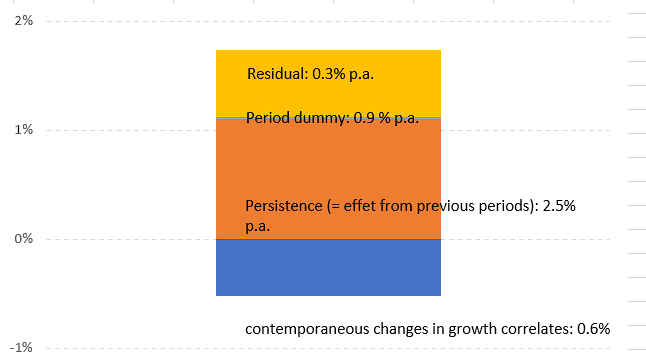